| Ознака           | Опис                                                                                                                             |
| ---------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| **Sepal.Length** | Довжина чашолистка (sepal) в сантиметрах — зеленої зовнішньої частини квітки, що її захищає перед розкриттям  |
| **Sepal.Width**  | Ширина чашолистка (sepal) в сантиметрах — поперечне перетинання тієї ж захисної структури                        |
| **Petal.Length** | Довжина пелюстки (petal) в сантиметрах — кольорової внутрішньої частини квітки, що приваблює запилювачів  |
| **Petal.Width**  | Ширина пелюстки (petal) в сантиметрах — поперечне перетинання яскравої внутрішньої частини квітки            |



In [46]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer

plt.style.use('ggplot')
plt.rcParams['axes.titlecolor'] = 'black'


In [47]:
df = pd.read_csv('before/amazinum/data/Iris Dataset.csv',index_col='Id')
df.head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [48]:
print(df.shape)
print(df.isnull().any())
df.describe()

df['Species'].unique()


(150, 5)
SepalLengthCm    False
SepalWidthCm     False
PetalLengthCm    False
PetalWidthCm     False
Species          False
dtype: bool


array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [49]:
X = df.drop('Species',axis=1)
print(X.shape)
print(X.isnull().any())
X.describe()


(150, 4)
SepalLengthCm    False
SepalWidthCm     False
PetalLengthCm    False
PetalWidthCm     False
dtype: bool


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [50]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) ])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols) ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans()) ])

param_grid = {
    'kmeans__n_clusters': [2,3,4,5],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__n_init': [5,10,20,30],
    'kmeans__algorithm': ['lloyd','elkan'] }

def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

grid = GridSearchCV(pipeline,
                    param_grid,
                    scoring=silhouette_scorer,
                    cv=5,
                    error_score='raise')

grid.fit(X)

best_model = grid.best_estimator_
print('Best params: ', grid.best_params_)
print('Best silhouette score: ', grid.best_score_)


Best params:  {'kmeans__algorithm': 'elkan', 'kmeans__init': 'random', 'kmeans__n_clusters': 2, 'kmeans__n_init': 5}
Best silhouette score:  0.45734515292875333


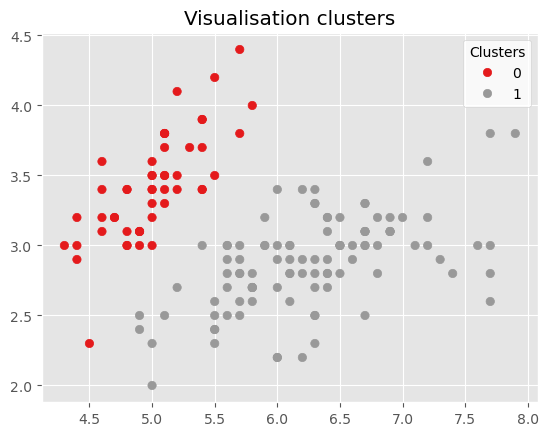

In [56]:
labels = best_model.named_steps['kmeans'].labels_

plt.figure
scatter = plt.scatter(X.iloc[:, 0], X.iloc[:,1], c=labels,cmap='Set1')
plt.title('Visualisation clusters')
plt.legend(*scatter.legend_elements(), title="Clusters",facecolor='white')
plt.show()


In [57]:
# порівняльна таблиця розподілу фіч
df_copy = df.copy()
df_copy['cluster'] = labels
pd.crosstab(df_copy['Species'], df_copy['cluster'])


cluster,0,1
Species,,
0,50,0
1,0,50
2,0,50


Silhouette Score:  0.6863930543445408


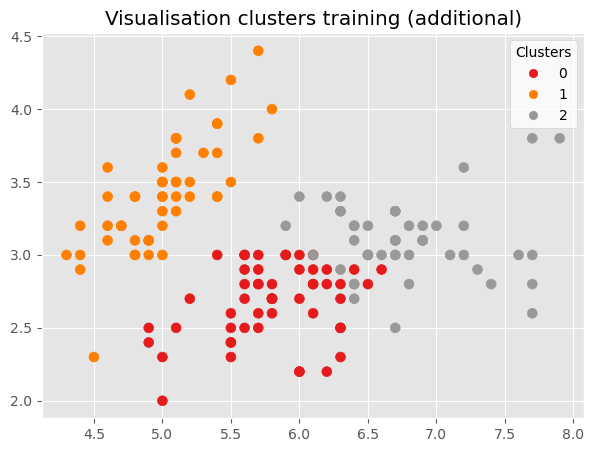

In [60]:
pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42))
])

pipeline1.fit(X)
labels1 = pipeline1.named_steps['kmeans'].labels_
print('Silhouette Score: ', silhouette_score(X, labels))


# Побудова графіка розсіювання
plt.figure(figsize=(7, 5))
scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels1, cmap='Set1', s=50)
plt.title('Visualisation clusters training (additional)')
plt.legend(*scatter.legend_elements(), title="Clusters",facecolor='white')
plt.grid(True)
plt.show()


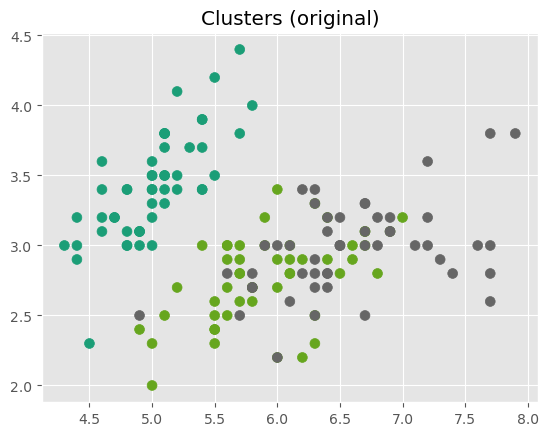

In [61]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_enc = df
df_enc['Species'] = le.fit_transform(df_enc['Species'])

plt.Figure(figsize=(7,5))
plt.title('Clusters (original)')
plt.scatter(df['SepalLengthCm'],df['SepalWidthCm'],c=df_enc['Species'], cmap='Dark2',s=50)
plt.show()


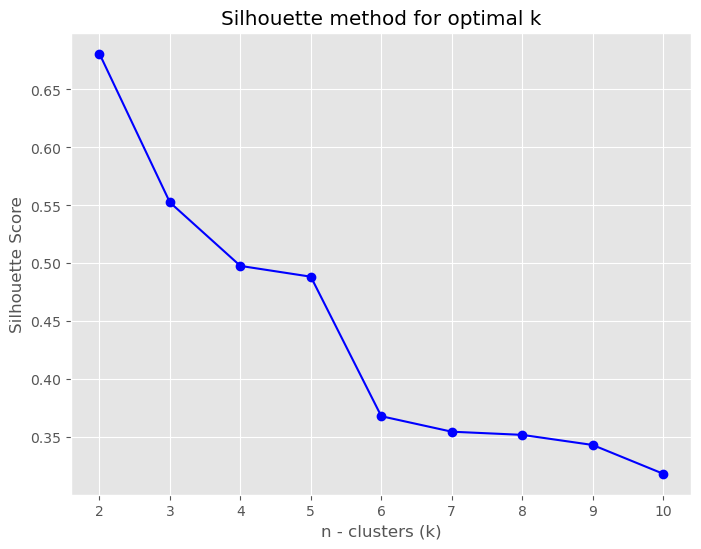

In [62]:
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('n - clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette method for optimal k')
plt.grid(True)
plt.show()


Висновок: ймовірно, через те, що точки різних кластерів змішані між собою або занадто близько між собою система кластеризує не зовсім так, як ми хочемо. Варто змінити алгоритм кластеризації чи виконати додаткову інженерію ознак, по якій система зможе краще ідентифікувати та кластеризувати точки, які знаходяться поблизу?